[INFO] Saving plots to: /media/alexandros/OS/Documents and Settings/alexp/Documents/Bachelor Thesis/report_figures/results/mRMR/lat_100/t_170_to_200/h_100_t_170_180_190_200_iso_0.8
Pooled rows total: n=14950 across timesteps=[170, 180, 190, 200]

Cluster features (common across all timesteps): ['curvature']
Model features (common across all timesteps):   ['curvature', 'dcurvdx', 'dcurvdy', 'du_ndx', 'du_ndy', 'u_n', 'u_t']

After dropna on required (cluster+model+target): n=14950


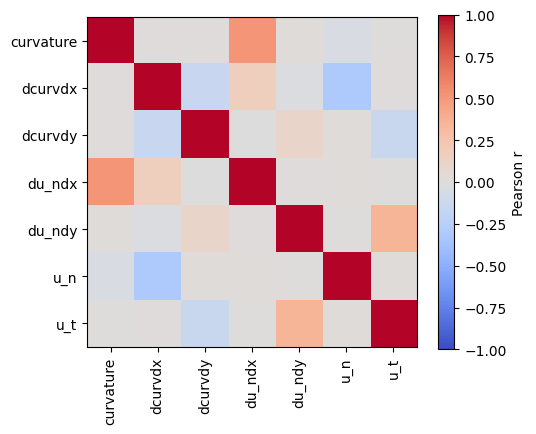

[INFO] Correlation plot saved: feature_corr_iso0.8_ts170-180-190-200

Curvature bins: (-0.1, 0.1) -> clusters 0..2

Curvature-bin cluster summary (pooled):
 cluster    n  sd_mean   sd_std  conf_mean  conf_max
       0 3114 0.725216 0.505653        1.0       1.0
       1 7893 1.147438 0.239281        1.0       1.0
       2 3943 1.160290 0.432072        1.0       1.0

Cluster occupancy / Sd mean by timestep:
 timestep  cluster    n  sd_mean  conf_mean
      170        0  725 0.729734        1.0
      170        1 1909 1.122522        1.0
      170        2 1165 1.110923        1.0
      180        0  796 0.736102        1.0
      180        1 1922 1.152191        1.0
      180        2 1021 1.140817        1.0
      190        0  820 0.618015        1.0
      190        1 2002 1.158639        1.0
      190        2  745 1.245973        1.0
      200        0  773 0.823489        1.0
      200        1 2060 1.155209        1.0
      200        2 1012 1.173688        1.0


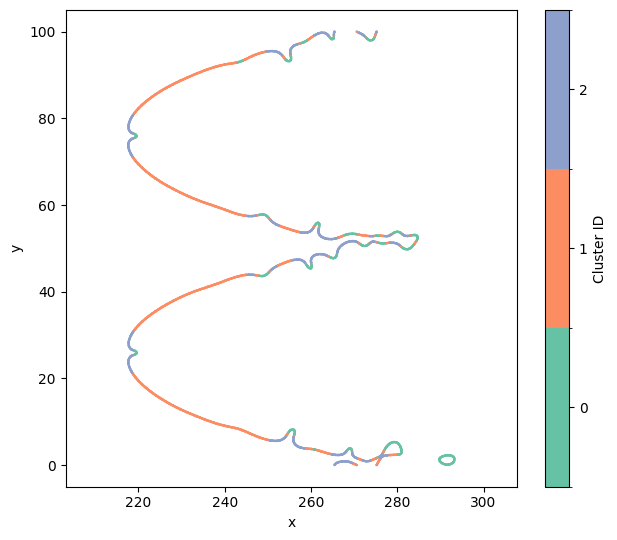

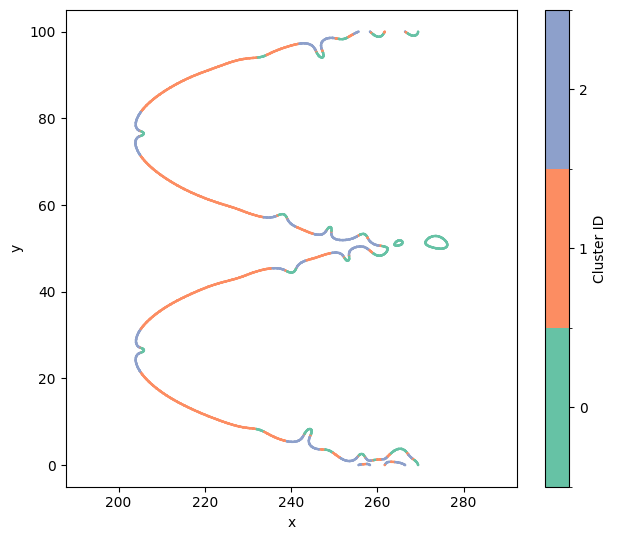

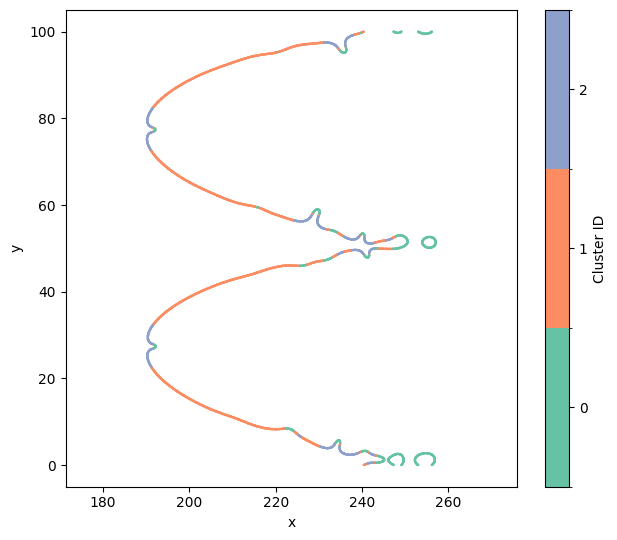

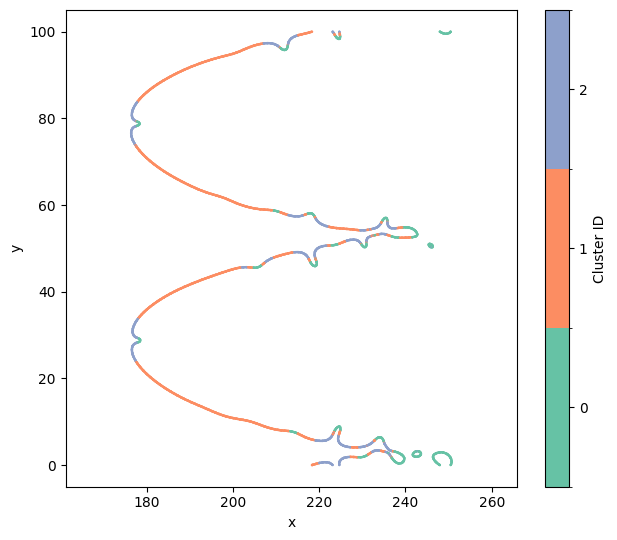


--- Cluster 0 (CURVATURE BIN) | n=3114 ---


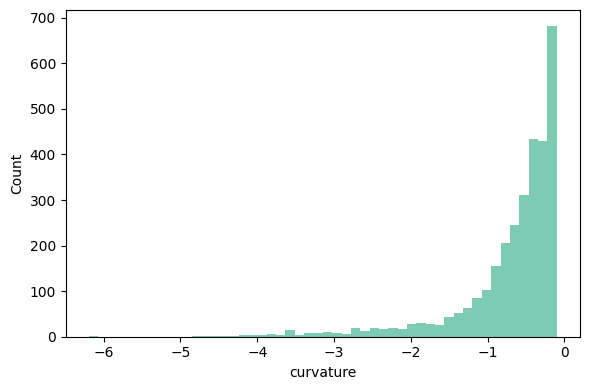

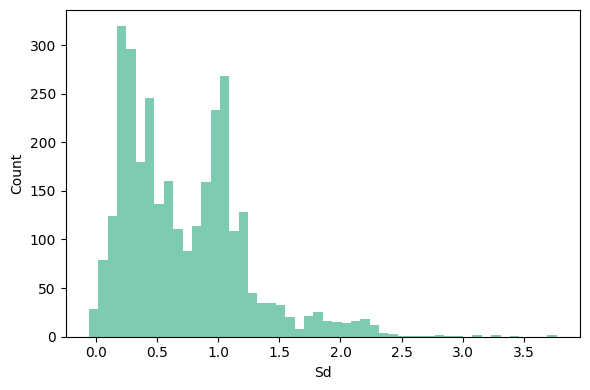

Top features (mRMR order):
  01. dcurvdx  (MI relevance = 0.8312)
  02. curvature  (MI relevance = 0.7907)
  03. dcurvdy  (MI relevance = 0.8182)
  04. du_ndy  (MI relevance = 0.6826)
  05. u_n  (MI relevance = 0.6209)
  06. du_ndx  (MI relevance = 0.6098)
  07. u_t  (MI relevance = 0.6081)


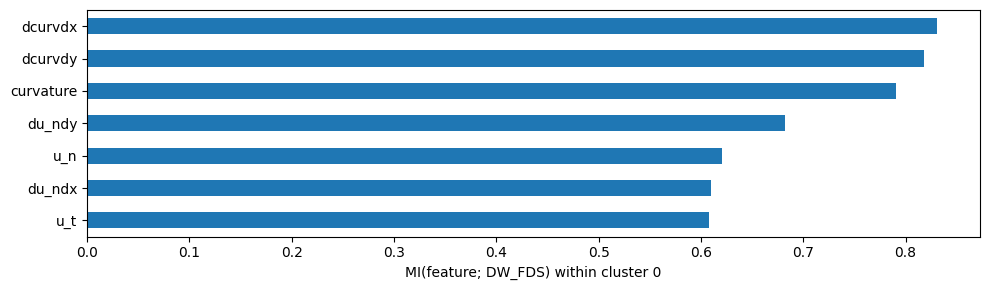


--- Cluster 1 (CURVATURE BIN) | n=7893 ---


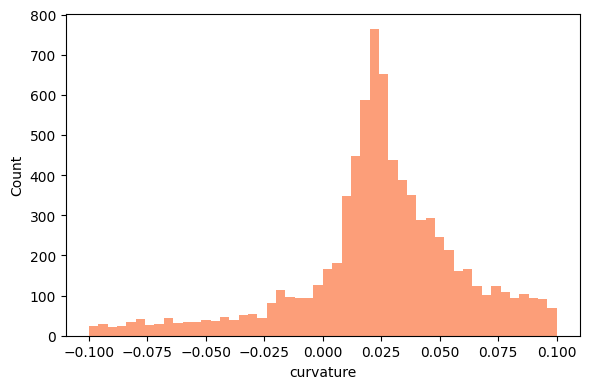

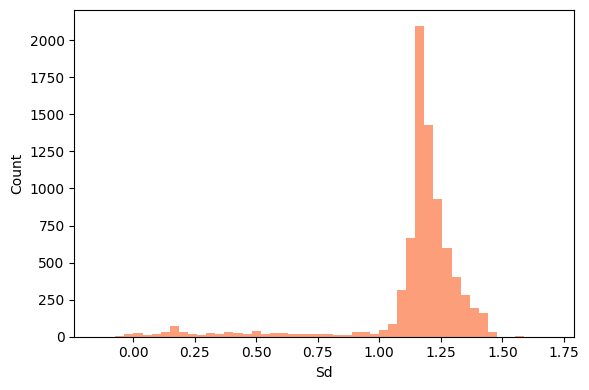

Top features (mRMR order):
  01. u_t  (MI relevance = 2.0642)
  02. dcurvdx  (MI relevance = 0.4385)
  03. curvature  (MI relevance = 0.9999)
  04. du_ndx  (MI relevance = 1.3724)
  05. du_ndy  (MI relevance = 1.0933)
  06. u_n  (MI relevance = 1.1494)
  07. dcurvdy  (MI relevance = 0.2840)


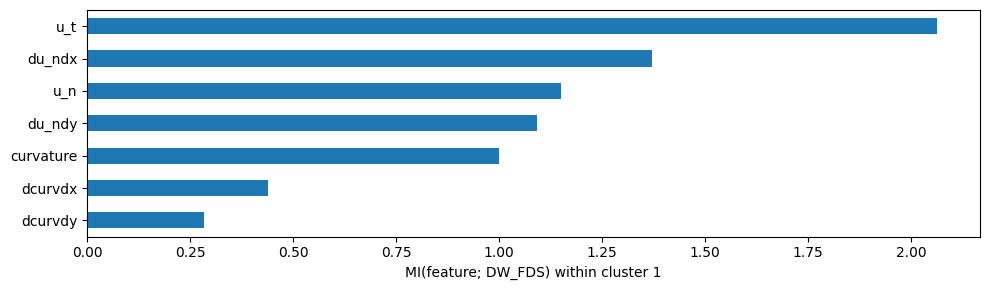


--- Cluster 2 (CURVATURE BIN) | n=3943 ---


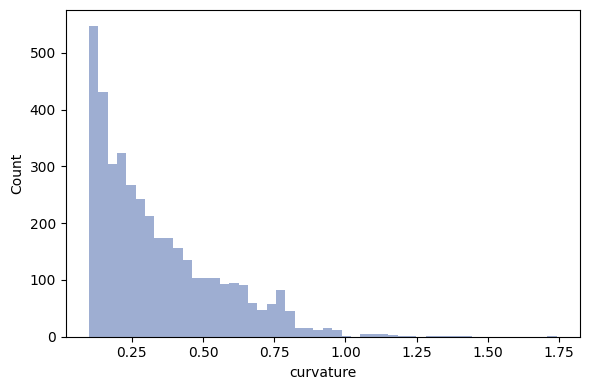

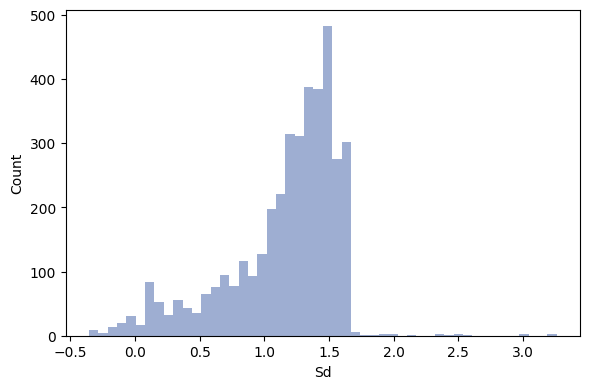

Top features (mRMR order):
  01. u_t  (MI relevance = 1.2103)
  02. dcurvdx  (MI relevance = 0.5654)
  03. du_ndy  (MI relevance = 1.0104)
  04. du_ndx  (MI relevance = 1.0756)
  05. curvature  (MI relevance = 0.5390)
  06. u_n  (MI relevance = 1.0116)
  07. dcurvdy  (MI relevance = 0.4136)


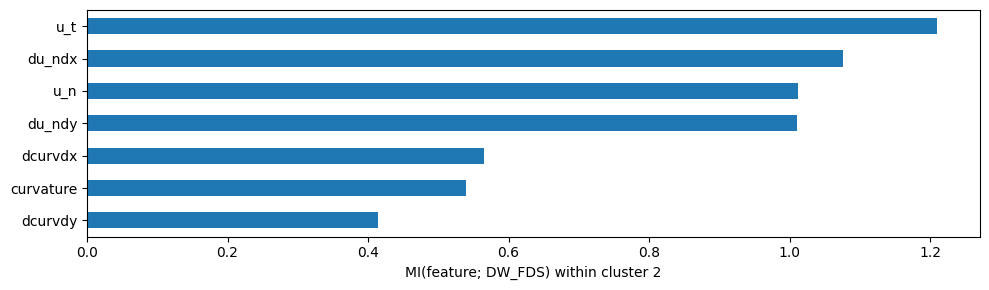


Summary (mRMR selected features per cluster):
 cluster  rank   feature  mi_relevance  n_cluster
       0     1   dcurvdx      0.831201       3114
       0     2 curvature      0.790736       3114
       0     3   dcurvdy      0.818200       3114
       0     4    du_ndy      0.682605       3114
       0     5       u_n      0.620918       3114
       0     6    du_ndx      0.609796       3114
       0     7       u_t      0.608117       3114
       1     1       u_t      2.064175       7893
       1     2   dcurvdx      0.438473       7893
       1     3 curvature      0.999915       7893
       1     4    du_ndx      1.372356       7893
       1     5    du_ndy      1.093298       7893
       1     6       u_n      1.149422       7893
       1     7   dcurvdy      0.284042       7893
       2     1       u_t      1.210350       3943
       2     2   dcurvdx      0.565435       3943
       2     3    du_ndy      1.010351       3943
       2     4    du_ndx      1.075606       3943
   

In [5]:
from __future__ import annotations

import os
os.chdir("..")   # go from notebooks/ to project root

from flamekit.io_fronts import Case, load_fronts
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Optional

from sklearn.feature_selection import mutual_info_regression

# =========================
# USER SETTINGS
# =========================

BASE_DIR = Path(r"/media/alexandros/OS/Documents and Settings/alexp/Documents/Bachelor Thesis/Code/isocontours")
PHI = 0.40
LAT_SIZE = "100"
POST = True

TIME_STEPS = [170, 180, 190, 200]
ISOLEVEL = 0.8
TARGET_VAR = "DW_FDS"
TARGET_LABEL = "Sd"
HIST_BINS = 50

CLUSTER_ON_SPATIAL = False

CLUSTER_FEATURES_INCLUDE = {
    "curvature",
}

MODEL_FEATURES_INCLUDE = {
    "curvature",
    "dcurvdx",
    "dcurvdy",
    "u_n",
    "u_t",
    "du_ndx",
    "du_ndy",
}

FEATURES_EXCLUDE = set()

CURVATURE_COLUMN = "curvature"
CURVATURE_BOUNDS = (-0.1, 0.1)  # low/high thresholds for 3 bins
N_CLUSTERS = len(CURVATURE_BOUNDS) + 1

K_SELECT_PER_CLUSTER = 12
MIN_CLUSTER_SAMPLES = 50
RANDOM_STATE = 0

MI_TOPN_PLOT = 15


# =========================
# PLOT SAVING (folder naming convention)
# =========================

OUTPUT_BASE_DIR = Path(r"/media/alexandros/OS/Documents and Settings/alexp/Documents/Bachelor Thesis/report_figures/results/mRMR")

def _time_steps_tag(time_steps: list[int]) -> str:
    if not time_steps:
        return "t_none"
    if len(time_steps) == 1:
        return f"t_{time_steps[0]}"
    t_min = min(time_steps)
    t_max = max(time_steps)
    return f"t_{t_min}_to_{t_max}"

RUN_DIR = OUTPUT_BASE_DIR / f"lat_{LAT_SIZE}" / _time_steps_tag(TIME_STEPS)
TS_TAG = "_".join(map(str, TIME_STEPS))
SAVE_DIR = RUN_DIR / f"h_{LAT_SIZE}_t_{TS_TAG}_iso_{ISOLEVEL}"
SAVE_DIR.mkdir(parents=True, exist_ok=True)

FIG_DPI = 300

def _safe_name(s: str) -> str:
    return "".join(ch if (ch.isalnum() or ch in "._-") else "_" for ch in s)

def save_png(stem: str, dpi: int = FIG_DPI):
    """Save current matplotlib figure as PNG to SAVE_DIR."""
    fname = SAVE_DIR / f"{_safe_name(stem)}.png"
    plt.gcf().savefig(fname, dpi=dpi, bbox_inches="tight", facecolor="white")

def save_then_show(stem: str, dpi: int = FIG_DPI):
    save_png(stem, dpi=dpi)
    plt.show()

print(f"[INFO] Saving plots to: {SAVE_DIR}")


# =========================
# Utilities
# =========================

def _numeric_cols(df: pd.DataFrame) -> List[str]:
    return [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]

def resolve_features(
    df: pd.DataFrame,
    include: Optional[List[str] | set[str]],
    exclude: set[str],
) -> List[str]:
    num = set(_numeric_cols(df))
    feats = num if include is None else set(include).intersection(num)
    feats = feats.difference(exclude)
    return sorted(feats)

def intersect_feature_space(feature_sets: List[set[str]]) -> List[str]:
    if not feature_sets:
        return []
    common = set.intersection(*feature_sets)
    return sorted(common)

def _cluster_cmap_and_norm(n_clusters: int):
    """
    Nice, visible, colorblind-friendly discrete colors.
    - For small k: use Set2 (pleasant + distinct)
    - For larger: fall back to tab10/tab20
    """
    from matplotlib.colors import ListedColormap, BoundaryNorm

    if n_clusters <= 8:
        base = plt.get_cmap("Set2")
        colors = [base(i) for i in range(n_clusters)]
    elif n_clusters <= 10:
        base = plt.get_cmap("tab10")
        colors = [base(i) for i in range(n_clusters)]
    else:
        base = plt.get_cmap("tab20")
        colors = [base(i) for i in range(n_clusters)]

    cmap = ListedColormap(colors)
    boundaries = np.arange(-0.5, n_clusters + 0.5, 1.0)
    norm = BoundaryNorm(boundaries, ncolors=n_clusters)
    return cmap, norm, boundaries

def labeled_cluster_plot_xy(dfc: pd.DataFrame, n_clusters: int, title: str):
    """
    XY plot with discrete colors and a discrete colorbar (exactly n_clusters).
    Titles removed.
    """
    if "x" not in dfc.columns or "y" not in dfc.columns:
        return

    cmap, norm, boundaries = _cluster_cmap_and_norm(n_clusters)

    plt.figure(figsize=(6.5, 5.5))
    sc = plt.scatter(
        dfc["x"], dfc["y"],
        c=dfc["cluster"].astype(int),
        s=3,
        cmap=cmap,
        norm=norm,
        edgecolors="none",
    )

    plt.axis("equal")
    plt.xlabel("x")
    plt.ylabel("y")
    # REMOVED: plt.title(title)

    cbar = plt.colorbar(
        sc,
        ticks=np.arange(n_clusters),
        boundaries=boundaries,
        spacing="proportional",
    )
    cbar.set_label("Cluster ID")
    cbar.ax.set_yticklabels([str(i) for i in range(n_clusters)])

    plt.tight_layout()
    save_then_show(f"clusters_xy_iso{ISOLEVEL}_ts{int(dfc['timestep'].iloc[0])}_k{n_clusters}")


def _cluster_color(cluster_id: int, n_clusters: int):
    cmap, _, _ = _cluster_cmap_and_norm(n_clusters)
    if hasattr(cmap, "colors") and cluster_id < len(cmap.colors):
        return cmap.colors[cluster_id]
    denom = max(n_clusters - 1, 1)
    return cmap(cluster_id / denom)


def plot_curvature_distribution(
    sub: pd.DataFrame,
    cluster_id: int,
    curvature_col: str,
    bins: int,
    n_clusters: int,
):
    if curvature_col not in sub.columns or len(sub) == 0:
        return
    color = _cluster_color(cluster_id, n_clusters)
    plt.figure(figsize=(6, 4))
    plt.hist(sub[curvature_col].to_numpy(), bins=bins, color=color, alpha=0.85)
    plt.xlabel(curvature_col)
    plt.ylabel("Count")
    plt.tight_layout()
    save_then_show(
        f"curvature_dist_iso{ISOLEVEL}_ts{'-'.join(map(str, TIME_STEPS))}_cluster{cluster_id}_n{len(sub)}"
    )


def plot_target_distribution(
    sub: pd.DataFrame,
    cluster_id: int,
    target_var: str,
    target_label: str,
    bins: int,
    n_clusters: int,
):
    if target_var not in sub.columns or len(sub) == 0:
        return
    color = _cluster_color(cluster_id, n_clusters)
    plt.figure(figsize=(6, 4))
    plt.hist(sub[target_var].to_numpy(), bins=bins, color=color, alpha=0.85)
    plt.xlabel(target_label)
    plt.ylabel("Count")
    plt.tight_layout()
    save_then_show(
        f"{target_label}_dist_iso{ISOLEVEL}_ts{'-'.join(map(str, TIME_STEPS))}_cluster{cluster_id}_n{len(sub)}"
    )


def mrmr_greedy(
    X: np.ndarray,
    y: np.ndarray,
    feature_cols: List[str],
    k_select: int,
    random_state: int = 0,
) -> Tuple[List[str], pd.Series]:
    """
    Greedy mRMR: score(j) = I(Xj; y) - mean_{s in selected} I(Xj; Xs)
    """
    n_samples, n_features = X.shape
    if n_features == 0:
        return [], pd.Series(dtype=float)

    k_select = int(min(k_select, n_features))

    mi_ft = mutual_info_regression(X, y, random_state=random_state)
    mi_rank = pd.Series(mi_ft, index=feature_cols).sort_values(ascending=False)

    # redundancy MI matrix
    mi_ff = np.zeros((n_features, n_features), dtype=float)
    for i in range(n_features):
        Xi = X[:, [i]]
        for j in range(i + 1, n_features):
            Xj = X[:, j]
            mi_ij = mutual_info_regression(Xi, Xj, random_state=random_state)[0]
            mi_ff[i, j] = mi_ij
            mi_ff[j, i] = mi_ij

    selected_idx: List[int] = []
    selected_feats: List[str] = []

    for _ in range(k_select):
        best_score = -np.inf
        best_j: Optional[int] = None

        for j in range(n_features):
            if j in selected_idx:
                continue
            relevance = mi_ft[j]
            redundancy = 0.0 if len(selected_idx) == 0 else float(np.mean([mi_ff[j, s] for s in selected_idx]))
            score = relevance - redundancy

            if score > best_score:
                best_score = score
                best_j = j

        if best_j is None:
            break

        selected_idx.append(best_j)
        selected_feats.append(feature_cols[best_j])

    return selected_feats, mi_rank


# ============================================================
# LOAD + POOL
# ============================================================

dfs = []
cluster_feature_sets_per_t: List[set[str]] = []
model_feature_sets_per_t: List[set[str]] = []

cluster_include = set(CLUSTER_FEATURES_INCLUDE)
if CLUSTER_ON_SPATIAL:
    cluster_include = cluster_include.union({"x", "y", "z"})

model_include = set(MODEL_FEATURES_INCLUDE)

for ts in TIME_STEPS:
    CASE = Case(
        base_dir=BASE_DIR,
        phi=PHI,
        lat_size=LAT_SIZE,
        time_step=ts,
        post=POST,
    )

    fronts = load_fronts(CASE, [ISOLEVEL])
    if ISOLEVEL not in fronts:
        raise ValueError(f"ISOLEVEL {ISOLEVEL} not found for timestep {ts}")

    df_t = fronts[ISOLEVEL].copy()
    df_t["c_iso"] = float(ISOLEVEL)
    df_t["timestep"] = int(ts)

    if TARGET_VAR not in df_t.columns:
        raise ValueError(f"TARGET_VAR '{TARGET_VAR}' not found for timestep {ts}")

    cl_feats_t = set(resolve_features(df_t, cluster_include, FEATURES_EXCLUDE))
    ml_feats_t = set(resolve_features(df_t, model_include, FEATURES_EXCLUDE))

    cluster_feature_sets_per_t.append(cl_feats_t)
    model_feature_sets_per_t.append(ml_feats_t)

    dfs.append(df_t)

df_all = pd.concat(dfs, ignore_index=True)
print(f"Pooled rows total: n={len(df_all)} across timesteps={TIME_STEPS}")

cluster_features = intersect_feature_space(cluster_feature_sets_per_t)
model_features = intersect_feature_space(model_feature_sets_per_t)

if len(cluster_features) == 0:
    raise ValueError("No common numeric CLUSTER features across requested timesteps. Adjust CLUSTER_FEATURES_INCLUDE.")
if len(model_features) == 0:
    raise ValueError("No common numeric MODEL features across requested timesteps. Adjust MODEL_FEATURES_INCLUDE.")

print(f"\nCluster features (common across all timesteps): {cluster_features}")
print(f"Model features (common across all timesteps):   {model_features}")

required = sorted(set(cluster_features).union(model_features).union({TARGET_VAR, CURVATURE_COLUMN}))
dfc = df_all.dropna(subset=required).copy()
print(f"\nAfter dropna on required (cluster+model+target): n={len(dfc)}")

# ============================================================
# FEATURE CORRELATION (global)
# ============================================================

def plot_feature_correlation(
    df: pd.DataFrame,
    features: List[str],
    stem: str,
):
    if not features:
        print("[WARN] No features provided for correlation plot.")
        return

    corr = df[features].corr()

    plt.figure(figsize=(0.35 * len(features) + 3, 0.35 * len(features) + 2))
    plt.imshow(corr.to_numpy(), vmin=-1, vmax=1, cmap="coolwarm")
    plt.xticks(np.arange(len(features)), features, rotation=90)
    plt.yticks(np.arange(len(features)), features)
    plt.colorbar(label="Pearson r")
    plt.tight_layout()
    save_then_show(stem)

    print(f"[INFO] Correlation plot saved: {stem}")

plot_feature_correlation(
    df=dfc,
    features=list(model_features),
    stem=f"feature_corr_iso{ISOLEVEL}_ts{'-'.join(map(str, TIME_STEPS))}",
)



# ============================================================
# CURVATURE BINNING (predefined thresholds)
# ============================================================

curv_col = CURVATURE_COLUMN
if curv_col not in dfc.columns:
    raise ValueError(f"CURVATURE_COLUMN '{curv_col}' not found in dataframe")

if len(CURVATURE_BOUNDS) != 2:
    raise ValueError("CURVATURE_BOUNDS must contain exactly two values")
low, high = CURVATURE_BOUNDS
if low >= high:
    raise ValueError("CURVATURE_BOUNDS must be strictly increasing (low < high)")

dfc["cluster"] = np.digitize(
    dfc[curv_col].to_numpy(),
    bins=[low, high],
    right=True,
)
dfc["cluster_conf"] = 1.0

print(f"\nCurvature bins: {CURVATURE_BOUNDS} -> clusters 0..{N_CLUSTERS - 1}")

summary_global = (
    dfc.groupby("cluster")
    .agg(
        n=(TARGET_VAR, "size"),
        sd_mean=(TARGET_VAR, "mean"),
        sd_std=(TARGET_VAR, "std"),
        conf_mean=("cluster_conf", "mean"),
        conf_max=("cluster_conf", "max"),
    )
    .reset_index()
    .sort_values("cluster")
)
print("\nCurvature-bin cluster summary (pooled):")
print(summary_global.to_string(index=False))

summary_by_t = (
    dfc.groupby(["timestep", "cluster"])
    .agg(n=(TARGET_VAR, "size"), sd_mean=(TARGET_VAR, "mean"), conf_mean=("cluster_conf", "mean"))
    .reset_index()
    .sort_values(["timestep", "cluster"])
)
print("\nCluster occupancy / Sd mean by timestep:")
print(summary_by_t.to_string(index=False))

for ts in TIME_STEPS:
    sub = dfc[dfc["timestep"] == ts]
    if len(sub) == 0:
        continue
    labeled_cluster_plot_xy(
        sub, N_CLUSTERS,
        title=f"CURVATURE bins | isotherm {ISOLEVEL} | timestep {ts}"
    )


# ============================================================
# Per-cluster mRMR feature selection
# ============================================================

selected_rows: List[dict] = []
mi_relevance: Dict[int, pd.Series] = {}

feature_names = list(model_features)

for cl in range(N_CLUSTERS):
    sub = dfc[dfc["cluster"] == cl].copy()
    n_cl = len(sub)
    print(f"\n--- Cluster {cl} (CURVATURE BIN) | n={n_cl} ---")

    if n_cl > 0:
        plot_curvature_distribution(
            sub,
            cluster_id=cl,
            curvature_col=CURVATURE_COLUMN,
            bins=HIST_BINS,
            n_clusters=N_CLUSTERS,
        )
        plot_target_distribution(
            sub,
            cluster_id=cl,
            target_var=TARGET_VAR,
            target_label=TARGET_LABEL,
            bins=HIST_BINS,
            n_clusters=N_CLUSTERS,
        )

    if n_cl < MIN_CLUSTER_SAMPLES:
        print(f"Skipping (n < MIN_CLUSTER_SAMPLES={MIN_CLUSTER_SAMPLES})")
        continue

    X = sub[model_features].to_numpy()
    y = sub[TARGET_VAR].to_numpy()

    selected, mi_rank = mrmr_greedy(
        X=X,
        y=y,
        feature_cols=feature_names,
        k_select=K_SELECT_PER_CLUSTER,
        random_state=RANDOM_STATE,
    )

    mi_relevance[cl] = mi_rank

    print("Top features (mRMR order):")
    for i, f in enumerate(selected, 1):
        print(f"  {i:02d}. {f}  (MI relevance = {mi_rank.loc[f]:.4f})")
        selected_rows.append({
            "cluster": cl,
            "rank": i,
            "feature": f,
            "mi_relevance": float(mi_rank.loc[f]),
            "n_cluster": int(n_cl),
        })

    topN = min(MI_TOPN_PLOT, len(mi_rank))
    if topN > 0:
        plt.figure(figsize=(10, 3))
        mi_rank.head(topN).iloc[::-1].plot(kind="barh")
        plt.xlabel(f"MI(feature; {TARGET_VAR}) within cluster {cl}")
        plt.tight_layout()
        save_then_show(
            f"mi_relevance_iso{ISOLEVEL}_ts{'-'.join(map(str, TIME_STEPS))}_cluster{cl}_top{topN}"
        )


# Save summary tables
if selected_rows:
    summary_df = pd.DataFrame(selected_rows)
    summary_csv = SAVE_DIR / "mrmr_selected_features.csv"
    summary_df.to_csv(summary_csv, index=False)

    print("\nSummary (mRMR selected features per cluster):")
    print(summary_df.to_string(index=False))
    print(f"\n[INFO] Wrote summary: {summary_csv}")
else:
    print("\nNo clusters met MIN_CLUSTER_SAMPLES; no mRMR results to report.")

if mi_relevance:
    mi_mat = pd.DataFrame(index=feature_names)
    for cl, mi_rank in mi_relevance.items():
        mi_mat[f"cluster_{cl}"] = mi_rank.reindex(feature_names)

    mi_csv = SAVE_DIR / "mi_relevance_per_cluster.csv"
    mi_mat.to_csv(mi_csv, index=True)
    print(f"\n[INFO] Wrote MI relevance matrix: {mi_csv}")

print(f"\nSaved PNG plots + summary files to: {SAVE_DIR}")
